This notebook is used to test the "Memory Augmented Optimizer" for BNN setting, the intuition is thta because we discard the softweight during update phase, some information is lost, this can slow down the training process. We want to see if we can use memory augmented bufffer to aggregate some information in the buffer to mitigate this effect.

In [19]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from torchvision.datasets import FashionMNIST, MNIST, CIFAR10, SVHN
from torch.autograd import Variable
import torchvision
from torchvision import transforms
import torchvision.utils as vision_utils
import matplotlib.pyplot as plt
import random
import os
import time
import math

DEVICE = torch.device('cuda')
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

In [20]:
def switch_to_device(dataset,device=None):
    final_X, final_Y = [], []
    for x, y in dataset:
        final_X.append(x)
        final_Y.append(y)
    X = torch.stack(final_X)
    Y = torch.tensor(final_Y)
    if device is not None:
        X = X.to(device)
        Y = Y.to(device)
    return torch.utils.data.TensorDataset(X, Y)


def get_mnist_dl(batch_size_train=1024, batch_size_eval=1024, device=torch.device('cuda')):
    transform = transforms.Compose([transforms.ToTensor()])
    
    data_train = MNIST('./datasets', train=True, download=True, transform=transform)
    data_train = switch_to_device(data_train, device=device)
    data_train, data_valid = torch.utils.data.random_split(data_train, [55000,5000])
    
    data_test = MNIST('./datasets', train=False, download=True, transform=transform)
    data_test = switch_to_device(data_test, device=device)
    
    train_dl = DataLoader(data_train, batch_size=batch_size_train, shuffle=True)
    valid_dl = DataLoader(data_valid, batch_size=batch_size_eval, shuffle=False)
    test_dl = DataLoader(data_test, batch_size=batch_size_eval, shuffle=False)
    
    return train_dl, valid_dl, test_dl

In [21]:
def print_stats(stats):
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (10, 3), dpi = 110)
    ax1.grid()
    ax2.grid()
    ax3.grid()

    ax1.set_title("ERM loss")
    ax2.set_title("Valid Acc")
    ax3.set_title("Norm of the True Gradient")

    ax1.set_xlabel("iterations")
    ax2.set_xlabel("iterations")
    ax3.set_xlabel("iterations")

    itrs = [x[0] for x in stats['train-loss']]
    loss = [x[1].cpu().detach().numpy() for x in stats['train-loss']]
    ax1.plot(itrs, loss)

    itrs = [x[0] for x in stats['valid-acc']]
    acc = [x[1] for x in stats['valid-acc']]
    ax2.plot(itrs, acc)

    itrs = [x[0] for x in stats['true_gradient_norm']]
    norm = [x[1].cpu().detach().numpy() for x in stats['true_gradient_norm']]
    ax3.plot(itrs, norm)

    ax1.set_ylim(0.0, np.max(loss))
    ax2.set_ylim(0.0, 1.05)
    ax3.set_ylim(0.0, np.max(norm))

In [22]:
@torch.no_grad()
def get_acc(model, dl, device = DEVICE):
    acc = []

    for X, y in dl:
        #y = y//2
        #one_hot_y = torch.zeros(X.shape[0], 5).to(device)
        #one_hot_y[[i for i in range(X.shape[0])], [k.item() for k in y]] = 1
        res = model.forward(X)
        acc.append(torch.argmax(res, dim = 1) == y)

    acc = torch.cat(acc)
    acc = torch.sum(acc)/len(acc)

    return acc.item()

In [23]:
def Binarize(x, quant_mode = 'det'):
    if quant_mode == 'det':
        return x.sign()
    else:
        return x.add_(1).div_(2).add_(torch.rand(x.size()).add(-0.5)).clamp_(0,1).round().mul_(2).add_(-1)

In [24]:
class BinarizeLinear(nn.Linear):

    def __init__(self, *kargs, **kwargs):
        super(BinarizeLinear, self).__init__(*kargs, **kwargs)

    def forward(self, input):

        if input.size(1) != 784:
            input.data=Binarize(input.data)

        if not hasattr(self.weight,'org'):
            self.weight.org=self.weight.data.clone()
        self.weight.data=Binarize(self.weight.org)
        out = nn.functional.linear(input, self.weight)

        if not self.bias is None:
            if not hasattr(self.bias,'org'):
                self.bias.org=self.bias.data.clone()
            self.bias.data = Binarize(self.bias.org)
            out += self.bias.view(1, -1).expand_as(out)

        return out

In [25]:
class BMLP_1(nn.Module):
    def __init__(self):
        super(BMLP_1, self).__init__()
        self.fc_1 = BinarizeLinear(28*28, 1024, bias = True, device = DEVICE)
        self.htan_1 = nn.Hardtanh()
        self.bn_1 = nn.BatchNorm1d(1024, device = DEVICE)

        self.fc_2 = BinarizeLinear(1024, 1024, bias = True, device = DEVICE)
        self.htan_2 = nn.Hardtanh()
        self.bn_2 = nn.BatchNorm1d(1024, device = DEVICE)

        self.fc_3 = BinarizeLinear(1024, 1024, bias = True, device = DEVICE)
        self.htan_3 = nn.Hardtanh()
        self.bn_3 = nn.BatchNorm1d(1024, device = DEVICE)
        
        self.fc_4 = BinarizeLinear(1024, 10, bias = True, device = DEVICE)

    def forward(self, input):
        x = torch.reshape(input, (input.shape[0], 28*28))
        x = self.fc_1(x)
        x = self.bn_1(x)
        x = self.htan_1(x)
        #x = self.bn_1(x)

        x = self.fc_2(x)
        x = self.bn_2(x)
        x = self.htan_2(x)
        #x = self.bn_2(x)

        x = self.fc_3(x)
        x = self.bn_3(x)
        x = self.htan_3(x)
        #x = self.bn_3(x)
        
        x = self.fc_4(x)
        return x

In [26]:
class BMLP_2(nn.Module):
    def __init__(self):
        super(BMLP_2, self).__init__()
        self.fc_1 = BinarizeLinear(28*28, 1024, bias = True, device = DEVICE)
        self.ReLU_1 = nn.ReLU()

        self.fc_2 = BinarizeLinear(1024, 1024, bias = True, device = DEVICE)
        self.ReLU_2 = nn.ReLU()

        self.fc_3 = BinarizeLinear(1024, 1024, bias = True, device = DEVICE)
        self.ReLU_3 = nn.ReLU()
        
        self.fc_4 = BinarizeLinear(1024, 10, bias = True, device = DEVICE)

    
    def forward(self, input):
        x = torch.reshape(input, (input.shape[0], 28*28))
        #x = torch.matmul(x, self.down_sample.T)
        x = self.fc_1(x)
        x = self.ReLU_1(x)
        x = self.fc_2(x)
        x = self.ReLU_2(x)
        x = self.fc_3(x)
        x = self.ReLU_3(x)
        x = self.fc_4(x)
        return x

In [27]:
class MLP_1(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        self.fc_1 = nn.Linear(28*28, 1024)
        self.htan_1 = nn.Hardtanh()
        self.bn_1 = nn.BatchNorm1d(1024, device = DEVICE)

        self.fc_2 = nn.Linear(1024, 1024)
        self.htan_2 = nn.Hardtanh()
        self.bn_2 = nn.BatchNorm1d(1024, device = DEVICE)

        self.fc_3 = nn.Linear(1024, 1024)
        self.htan_3 = nn.Hardtanh()
        self.bn_3 = nn.BatchNorm1d(1024, device = DEVICE)
        
        self.fc_4 = nn.Linear(1024, num_classes)

    def forward(self, input):
        x = torch.reshape(input, (input.shape[0], 28*28))
        x = self.fc_1(x)
        #x = self.bn_1(x)
        x = self.htan_1(x)
        x = self.fc_2(x)
        #x = self.bn_2(x)
        x = self.htan_2(x)
        x = self.fc_3(x)
        #x = self.bn_3(x)
        x = self.htan_3(x)
        x = self.fc_4(x)

        return x

In [28]:
class MLP_2(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        self.fc_1 = nn.Linear(28*28, 1024)
        self.ReLU_1 = nn.ReLU()

        self.fc_2 = nn.Linear(1024, 1024)
        self.ReLU_2 = nn.ReLU()

        self.fc_3 = nn.Linear(1024, 1024)
        self.ReLU_3 = nn.ReLU()
        
        self.fc_4 = nn.Linear(1024, num_classes)

    def forward(self, input):
        x = torch.reshape(input, (input.shape[0], 28*28))
        x = self.fc_1(x)
        x = self.ReLU_1(x)
        x = self.fc_2(x)
        x = self.ReLU_1(x)
        x = self.fc_3(x)
        x = self.ReLU_1(x)
        x = self.fc_4(x)

        return x

In [29]:
def buffer_decay(vector_buffer, decay_rate = 0.9):
    new_buffer = {}
    for key in vector_buffer:
        new_buffer[key*decay_rate] = vector_buffer[key]
    del vector_buffer
    return new_buffer

In [30]:
def mean_aggregation(vector_buffer, new_vector):
    res = {}
    num = len(vector_buffer.keys())
    if num == 0:
        return new_vector
    
    for i, key in enumerate(vector_buffer.keys()):
        for j in vector_buffer[key].keys():
            if j not in res.keys():
                res[j] = vector_buffer[key][j].clone()
            else:
                res[j] += vector_buffer[key][j]
    
    for i in new_vector.keys():
        res[i]  = res[i].clone().view(1, -1) + new_vector[i]
        res[i] /= (num + 1)
    
    return res

In [31]:
def mean_sum_aggregation(vector_buffer, new_vector):
    res = {}
    num = len(vector_buffer.keys())
    if num == 0:
        return new_vector
    
    for i, key in enumerate(vector_buffer.keys()):
        for j in vector_buffer[key].keys():
            if j not in res.keys():
                res[j] = vector_buffer[key][j].clone()
            else:
                res[j] += vector_buffer[key][j]
    
    for i in new_vector.keys():
        res[i] /= num
        res[i]  = res[i].clone().view(1, -1) + new_vector[i]
    
    return res

In [32]:
def sum_aggregation(vector_buffer, new_vector):
    res = {}
    num = len(vector_buffer.keys())
    if num == 0:
        return new_vector
    
    for i, key in enumerate(vector_buffer.keys()):
        for j in vector_buffer[key].keys():
            if j not in res.keys():
                res[j] = vector_buffer[key][j].clone()
            else:
                res[j] += vector_buffer[key][j]

    for i in new_vector.keys():
        res[i]  = res[i].clone().view(1, -1) + new_vector[i]
    
    return res

In [33]:
def update_buffer(vector_buffer, new_vector, new_da, buffer_capacity, dir_align):
    largest = {}
    #sort_list, idx_list = torch.sort(torch.abs(new_da).view(-1), descending=True)
    #idx = idx_list[5]
    idx = torch.argmax(torch.abs(new_da))

    if len(vector_buffer.keys()) < buffer_capacity:
        align_sign = new_da[idx].sign()
        for i in new_vector.keys():
            if i not in largest.keys():
                if dir_align:
                    largest[i] = align_sign * new_vector[i][idx].clone()
                else:
                    largest[i] = new_vector[i][idx].clone()
        vector_buffer[torch.abs(new_da[idx])] = largest
        return vector_buffer

    min_norm = min(vector_buffer.keys())
    if min_norm > torch.abs(new_da[idx]):
        return vector_buffer

    del vector_buffer[min_norm]
    align_sign = new_da[idx].sign()
    for i in new_vector.keys():
        if i not in largest.keys():
            if dir_align:
                largest[i] = align_sign * new_vector[i][idx].clone()
            else:
                largest[i] = new_vector[i][idx].clone()

    vector_buffer[torch.abs(new_da[idx])] = largest

    return vector_buffer


In [34]:
def run_experiment(model, opt, criterion, train_dl, valid_dl, test_dl, max_epochs=20, use_forward_grad=False, num_dir=1, binarize_dir=False, softweight=True, adjust_da=True, use_memory_augmented=False, buffer_capacity=5, decay_rate=0.9, aggregate_method="mean", dir_align=False):
    itr = -1
    stats = {'train-loss':[], 'valid-acc':[], 'true_gradient_norm' : []}
    model.train()

    if use_forward_grad:
        random_dir = {}
        for i, p in enumerate(model.parameters()):
            random_dir[i] = 0

        if use_memory_augmented:
            vector_buffer = {}
        
    for epoch in range(max_epochs):
        for x, y in train_dl:
            itr += 1
            opt.zero_grad()
            loss = criterion(model(x), y)
            stats['train-loss'].append((itr, loss))
            loss.backward()
            
            vector_norm = 0
            for i, p in enumerate(model.parameters()):
                vector_norm += torch.norm(p.grad.view(-1))**2
            stats['true_gradient_norm'].append((itr, vector_norm))

            if use_forward_grad:
                with torch.no_grad():
                    da = torch.zeros((num_dir, 1), device = DEVICE)

                    for i, p in enumerate(model.parameters()):
                        g = p.grad.view(-1)
                        v = torch.randn(num_dir, len(g), device = DEVICE).sign()
                        random_dir[i] = v
                        da += (v @ g).view(num_dir, 1)
                    
                    if use_memory_augmented:
                        if aggregate_method == "mean":
                            final_dir = mean_aggregation(vector_buffer, random_dir)
                        elif aggregate_method == "mean_sum":
                            final_dir = mean_sum_aggregation(vector_buffer, random_dir)
                        elif aggregate_method == "sum":
                            final_dir = sum_aggregation(vector_buffer, random_dir)
                        vector_buffer = buffer_decay(vector_buffer, decay_rate)
                        vector_buffer = update_buffer(vector_buffer, random_dir, da, buffer_capacity, dir_align)
                    
                        if binarize_dir:
                            for i in final_dir.keys():
                                final_dir[i] = final_dir[i].sign()
                        
                    
                    else:
                        final_dir = random_dir
                    
                    da = torch.zeros((num_dir, 1), device = DEVICE)
                    for i, p in enumerate(model.parameters()):
                        g = p.grad.view(-1)
                        v = final_dir[i]
                        da += (v @ g).view(num_dir, 1)
                    
                    if adjust_da:
                        if itr >=5000:
                            da = da/5
                        elif itr >=10000:
                            da = da/10
                        elif itr >=15000:
                            da = da/20
                        elif itr >=20000:
                            da = da/30
                    
                    for i, p in enumerate(model.parameters()):
                        g = (da * final_dir[i]).mean(dim = 0)
                        p.grad = g.view(p.grad.shape)
            
            if softweight:
                for p in list(model.parameters()):
                    if hasattr(p, 'org'):
                        p.data.copy_(p.org)
            
            opt.step()
            
            for p in list(model.parameters()):
                if hasattr(p, 'org'):
                    if softweight:
                        p.org.copy_(p.data.clamp_(-1, 1))
                    else:
                        p.org.copy_(p.data.sign())
            
            if itr % 100 == 0:
                model.eval()
                valid_acc = get_acc(model, valid_dl, device = DEVICE)
                stats['valid-acc'].append((itr, valid_acc))
                s = f"{epoch}:{itr} [train] loss:{loss.item():.3f}, [valid] acc:{valid_acc:.3f}, [true_norm] norm:{vector_norm:.3f}"
                print(s)
                model.train()
    
    model.eval()
    test_acc = get_acc(model, test_dl, device=DEVICE)
    print(f"[test] acc:{test_acc:.3f}")
    return stats



In [35]:
model = BMLP_1().to(DEVICE)
opt = torch.optim.SGD(model.parameters(), lr = 1e-2)
criterion = nn.CrossEntropyLoss()

train_batch = 1024
valid_batch = 1024

max_epochs = 200

use_forward_grad = True
num_dir = 20
binarize_dir = True
softweight = True
adjust_da = False

use_memory_augmented = False
buffer_capacity = 5
decay_rate = 0.9
aggregate_method = "sum"
dir_align = True


0:0 [train] loss:49.784, [valid] acc:0.099, [true_norm] norm:28.645
1:100 [train] loss:29.322, [valid] acc:0.280, [true_norm] norm:13.951
3:200 [train] loss:25.795, [valid] acc:0.332, [true_norm] norm:9.844
5:300 [train] loss:23.986, [valid] acc:0.363, [true_norm] norm:10.590
7:400 [train] loss:19.712, [valid] acc:0.426, [true_norm] norm:7.812
9:500 [train] loss:18.695, [valid] acc:0.465, [true_norm] norm:7.520
11:600 [train] loss:16.651, [valid] acc:0.472, [true_norm] norm:6.610
12:700 [train] loss:17.784, [valid] acc:0.480, [true_norm] norm:7.213
14:800 [train] loss:17.029, [valid] acc:0.484, [true_norm] norm:5.294
16:900 [train] loss:16.333, [valid] acc:0.491, [true_norm] norm:5.654
18:1000 [train] loss:15.651, [valid] acc:0.508, [true_norm] norm:5.038
20:1100 [train] loss:15.987, [valid] acc:0.501, [true_norm] norm:5.039
22:1200 [train] loss:16.524, [valid] acc:0.506, [true_norm] norm:5.736
24:1300 [train] loss:15.334, [valid] acc:0.546, [true_norm] norm:5.495
25:1400 [train] loss:

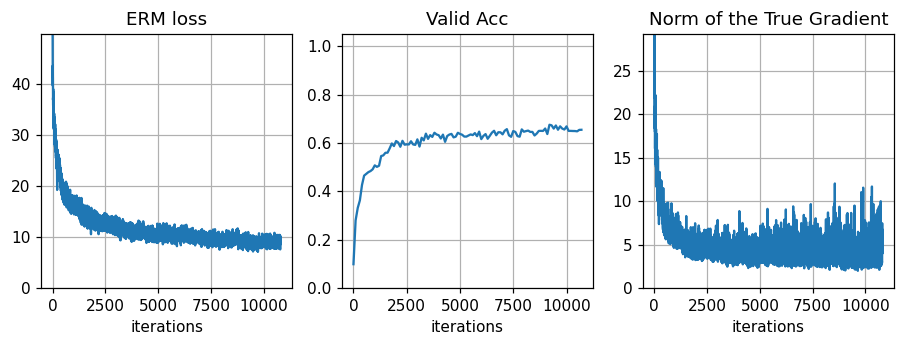

: 

In [36]:
train_dl, valid_dl, test_dl = get_mnist_dl(batch_size_train=train_batch, batch_size_eval=valid_batch, device = DEVICE)
stats = run_experiment(model, opt, criterion, train_dl, valid_dl, test_dl, max_epochs, use_forward_grad, num_dir, binarize_dir, softweight, adjust_da, use_memory_augmented, buffer_capacity, decay_rate, aggregate_method, dir_align)
print_stats(stats)